<a href="https://colab.research.google.com/github/Hadrien-Cornier/cool-nn-stuff/blob/main/keras_gamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Interesting Properties of the Gamma Function

### Extension of Factorial

The gamma function extends the concept of factorial to non-integer and even complex numbers. For positive integers n, it satisfies:

$$\Gamma(n) = (n-1)!$$

This property allows for the calculation of factorials for non-integer values, which is useful in many areas of mathematics and physics.

### Functional Equation

The gamma function satisfies a fundamental functional equation:

$$\Gamma(z+1) = z\Gamma(z)$$

This recursive property is analogous to the relationship between consecutive factorials and allows for the computation of gamma values for related arguments.

### Reflection Formula

For complex numbers with a non-integer real part, the gamma function satisfies Euler's reflection formula:

$$\Gamma(z)\Gamma(1-z) = \frac{\pi}{\sin(\pi z)}$$

This formula relates gamma function values of complementary arguments and is useful in complex analysis.

### Multiplication Theorem

The gamma function satisfies the multiplication theorem, also known as the Gauss multiplication formula:

$$\Gamma(nz) = (2\pi)^{\frac{1-n}{2}}n^{nz-\frac{1}{2}}\prod_{k=0}^{n-1}\Gamma(z+\frac{k}{n})$$

This theorem relates the gamma function of a multiple of z to a product of gamma functions.

### Logarithmic Derivative

The digamma function, defined as the logarithmic derivative of the gamma function, has important applications in statistics and machine learning:

$$\psi(z) = \frac{d}{dz}\ln(\Gamma(z)) = \frac{\Gamma'(z)}{\Gamma(z)}$$

### Analytic Continuation

The gamma function provides an analytic (= computable) continuation of the factorial function to complex numbers, except at non-positive integers where it has simple poles.

### Integral Representations

The gamma function has several integral representations, including:

1. Euler integral (for Re(z) > 0):
   $$\Gamma(z) = \int_0^\infty t^{z-1}e^{-t}dt$$

2. Hankel's contour integral (valid for all complex z):
   $$\Gamma(z) = \frac{1}{2i\sin(\pi z)}\int_{-\infty}^{(0+)}(-t)^{z-1}e^{-t}dt$$

### Connection to Other Special Functions

The gamma function is closely related to other special functions in mathematics, including the Beta function, which is a function that is useful in machine learning for computing classification probabilities

- Beta function: $$Β(x,y) = \frac{\Gamma(x)\Gamma(y)}{\Gamma(x+y)}$$



## Gamma Function Approximations

The gamma function has a few approximation methods : the Stirling approximation, the Lanczos approximation, and the Spouge approximation.

### Stirling Approximation

The Stirling approximation for the gamma function is given by:

$$\Gamma(z) = \sqrt{\frac{2\pi}{z}} \left(\frac{z}{e}\right)^z \left(1 + \frac{1}{12z} + \frac{1}{288z^2} - \frac{139}{51840z^3} - \frac{571}{2488320z^4} + \cdots\right)$$

This series continues infinitely, but in practice, it's often truncated after a few terms. The Stirling approximation is most accurate for large values of $z$ and is widely used in statistical applications due to its simplicity.

### Lanczos Approximation

The exact formula for the Lanczos approximation is more complex:

$$\Gamma(z + 1) = \frac{\sqrt{2\pi}}{\exp(z + s + \frac{1}{2})} (z + s + \frac{1}{2})^{z + \frac{1}{2}} \sum_{k=0}^{\infty} H(k, z) g(k, s)$$

Where:
$$H(k, z) = \frac{(-1)^k (-z)_k}{(z + 1)_k} = \frac{1}{(z + 1)_k (z + 1)_{-k}}$$
$$g(k, s) = \frac{(-1)^k (2^{\frac{1}{2} - \delta_k} \exp(s))}{\sqrt{\pi}}$$

Here, $(x)_k$ denotes the Pochhammer symbol, $s$ is a free parameter, and $\delta_k$ is the Kronecker delta. The Lanczos approximation is valid for all positive real values of $z$ and can be extended to complex numbers.

### Spouge Approximation

The Spouge approximation is a variant of the Lanczos approximation, designed for improved numerical efficiency.

$$\Gamma(z) = (z + a - \frac{1}{2})^{z - \frac{1}{2}} e^{-(z + a - \frac{1}{2})} \sqrt{2\pi} \left(c_0 + \sum_{k=1}^{a-1} \frac{c_k}{z + k}\right)$$

Where $a$ is a positive integer that controls the accuracy of the approximation, and $c_k$ are precomputed coefficients.

### Comparison of Approximations

| Approximation | Valid Range | Numerical Efficiency | Accuracy |
| --- | --- | --- | --- |
| Stirling | Large $z$ | High | Improves with larger $z$ |
| Lanczos | All positive real $z$ | Medium | High for all $z$ |
| Spouge | All positive real $z$ | High | Improves with larger $a$ |

The Stirling approximation is most suitable for large values of $z$ and offers high numerical efficiency. The Lanczos approximation provides high accuracy across all positive real values of $z$ but at a higher computational cost. The Spouge approximation offers a balance between accuracy and efficiency, with its accuracy improving as the parameter $a$ increases

In this notebook I implement the log gamma and digamma functions from scratch using only keras.ops instead of the tensorflow math library or jax. I use the Spouge approximation first

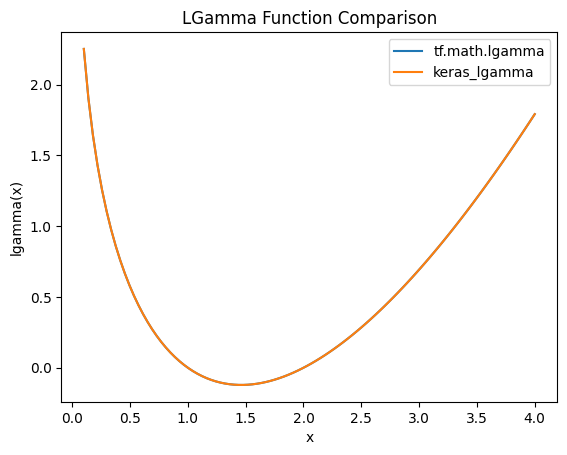

In [170]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import jax.numpy as jnp

def keras_lgamma(z):
    g = 7
    spouge_coeffs = keras.ops.array([
        0.99999999999980993,
        676.5203681218851,
        -1259.1392167224028,
        771.32342877765313,
        -176.61502916214059,
        12.507343278686905,
        -0.13857109526572012,
        9.9843695780195716e-6,
        1.5056327351493116e-7
    ])

    idxs = keras.ops.convert_to_tensor(keras.ops.arange(1, len(spouge_coeffs)), dtype='float32')
    pi = keras.ops.convert_to_tensor(3.141592653589793)
    sqrt_two_pi = keras.ops.sqrt(2 * pi)

    def lanczos(z):
        z = z - 1
        z_expanded = keras.ops.expand_dims(z, axis=-1)
        x = spouge_coeffs[0]
        x += keras.ops.sum(spouge_coeffs[1:] / (z_expanded + idxs), axis=-1)
        t = z + g + 0.5
        return sqrt_two_pi * (t ** (z + 0.5)) * keras.ops.exp(-t) * x

    less_than_half = keras.ops.less(z, 0.5)
    mask = keras.ops.convert_to_tensor(less_than_half, dtype='float32')
    z_reflected = (1 - z) * mask + z * (1 - mask)
    result = lanczos(z_reflected)
    reflection = pi / (keras.ops.sin(pi * z) * result)
    return keras.ops.log(reflection * mask + result * (1 - mask))

x = tf.linspace(0.1, 4, 100)
plt.plot(x, tf.math.lgamma(x), label='tf.math.lgamma')
plt.plot(x, keras_lgamma(x), label='keras_lgamma')
plt.xlabel('x')  # Add x-axis label
plt.ylabel('lgamma(x)')  # Add y-axis label
plt.title('LGamma Function Comparison')  # Add a title
plt.legend()  # Show legend to distinguish the two lines
plt.show()

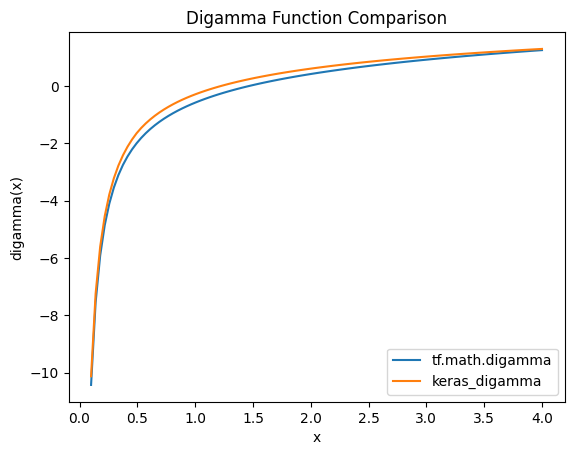

In [171]:
def keras_digamma(z):
    g = 7
    spouge_coeffs = keras.ops.array([
        0.99999999999980993,
        676.5203681218851,
        -1259.1392167224028,
        771.32342877765313,
        -176.61502916214059,
        12.507343278686905,
        -0.13857109526572012,
        9.9843695780195716e-6,
        1.5056327351493116e-7
    ])

    idxs = keras.ops.convert_to_tensor(keras.ops.arange(1, len(spouge_coeffs)), dtype='float32')
    pi = keras.ops.convert_to_tensor(3.141592653589793)
    euler_mascheroni = keras.ops.convert_to_tensor(0.5772156649015329)

    def digamma_lanczos(z):
        z = z - 1
        z_expanded = keras.ops.expand_dims(z, axis=-1)

        sum_term = keras.ops.sum(spouge_coeffs[1:] / (z_expanded + idxs), axis=-1)
        sum_term_derivative = -keras.ops.sum(spouge_coeffs[1:] / ((z_expanded + idxs) ** 2), axis=-1)

        t = z + g + 0.5
        log_term = keras.ops.log(t) - 1 / (2 * t)

        return log_term + (sum_term_derivative / (spouge_coeffs[0] + sum_term)) - euler_mascheroni

    less_than_half = keras.ops.less(z, 0.5)
    mask = keras.ops.convert_to_tensor(less_than_half, dtype='float32')
    z_reflected = (1 - z) * mask + z * (1 - mask)

    result = digamma_lanczos(z_reflected)

    # Apply reflection formula for z < 0.5, because it is more accurate
    reflection = pi * keras.ops.cos(pi * z) / keras.ops.sin(pi * z)

    return (result - reflection) * mask + result * (1 - mask)

# Test
import matplotlib.pyplot as plt
import tensorflow as tf

x = tf.linspace(0.1, 4, 100)
plt.plot(x, tf.math.digamma(x), label='tf.math.digamma')
plt.plot(x, keras_digamma(x), label='keras_digamma')
plt.xlabel('x')
plt.ylabel('digamma(x)')
plt.title('Digamma Function Comparison')
plt.legend()
plt.show()